In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import scipy.io as sio
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
!wget http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat

--2023-03-22 11:45:06--  http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat [following]
--2023-03-22 11:45:06--  https://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34806917 (33M)
Saving to: ‘PaviaU.mat’

PaviaU.mat          100%[===================>]  33.19M   142KB/s    in 3m 35s  

2023-03-22 11:48:42 (158 KB/s) - ‘PaviaU.mat’ saved [34806917/34806917]

URL transformed to HTTPS due to an HSTS policy
--2023-03-22 11:48:42--  https://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 O

In [ ]:
!ls

PaviaU_gt.mat  PaviaU.mat  sample_data


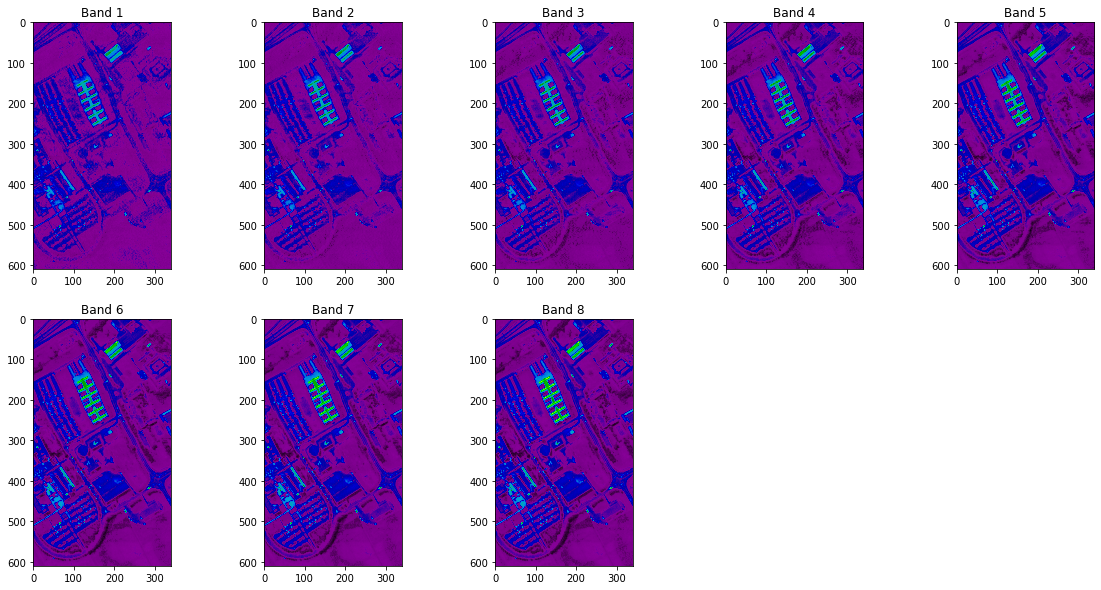

In [ ]:
# load the dataset
data = sio.loadmat('PaviaU.mat')['paviaU']

# extract the spectral data
spectral_data = np.reshape(data, (-1, data.shape[-1]))

# display the spectral bands before PCA
plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(2, 5, i+1)
    plt.imshow(data[:, :, i], cmap='nipy_spectral')
    plt.title('Band {}'.format(i+1))
plt.show()



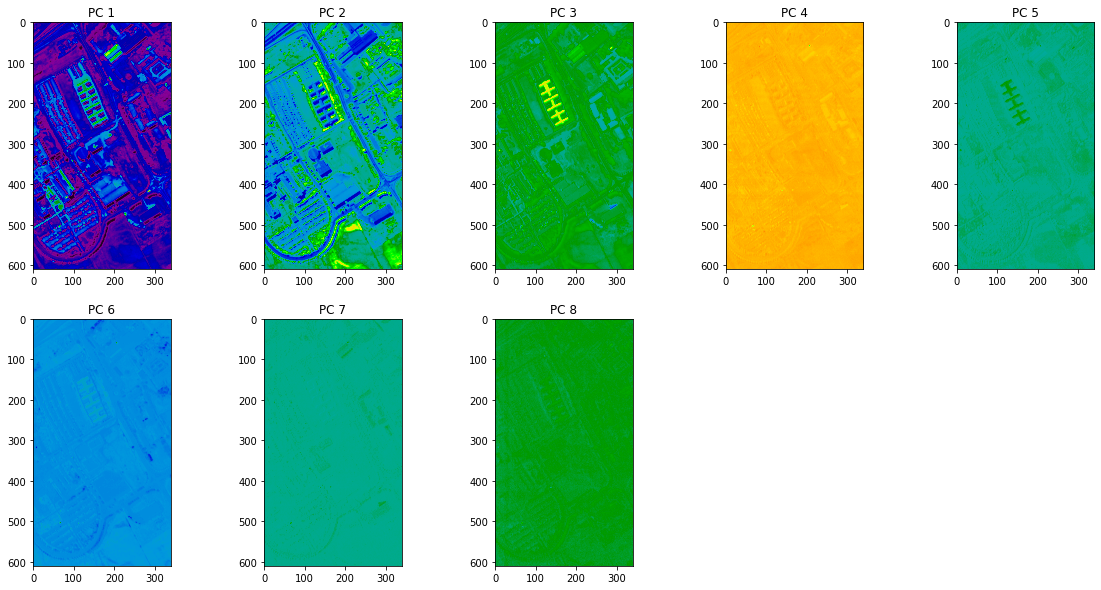

In [ ]:

# calculate the covariance matrix
covariance_matrix = np.cov(spectral_data.T)

# calculate the eigenvectors and eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

# sort the eigenvectors in descending order based on their corresponding eigenvalues
eigenvectors_sorted = eigenvectors[:, eigenvalues.argsort()[::-1]]

# choose the top k eigenvectors as the principal components
k = 30
principal_components = eigenvectors_sorted[:, :k]

# project the original data onto the new feature space
reduced_data = np.dot(spectral_data, principal_components)

# display the spectral bands after PCA
plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.reshape(reduced_data[:, i], (610, 340)), cmap='nipy_spectral')
    plt.title('PC {}'.format(i+1))
plt.show()



In [ ]:

# load the ground truth data
gt_data = sio.loadmat('PaviaU_gt.mat')['paviaU_gt']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(reduced_data, gt_data.ravel(), test_size=0.3, random_state=42)

# perform PCA on the testing data using the same eigenvectors as the training data
data_test = sio.loadmat('PaviaU.mat')['paviaU']
spectral_data_test = np.reshape(data_test, (-1, data_test.shape[-1]))
mean_data_test = np.mean(spectral_data_test, axis=0)
centered_data_test = spectral_data_test - mean_data_test
reduced_data_test = np.dot(centered_data_test, principal_components)

# train the k-nearest neighbors classifier on the original data
knn_original = KNeighborsClassifier(n_neighbors=5)
knn_original.fit(spectral_data, gt_data.ravel())

# train the k-nearest neighbors classifier on the reduced data
knn_reduced = KNeighborsClassifier(n_neighbors=5)
knn_reduced.fit(X_train, y_train)

# evaluate the accuracy of the classifiers on the testing data
y_pred_original = knn_original.predict(spectral_data_test)
y_pred_reduced = knn_reduced.predict(reduced_data_test)

accuracy_original = accuracy_score(gt_data.ravel(), y_pred_original)
accuracy_reduced = accuracy_score(gt_data.ravel(), y_pred_reduced)

print(f"Accuracy before applying PCA in KNN: {accuracy_original}")
print(f"Accuracy after applying PCA in KNN: {accuracy_reduced}")


Accuracy before applying PCA in KNN: 0.8859932497589199
Accuracy after applying PCA in KNN: 0.7806991321118611
